In [11]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

import torch
from torch import nn, optim
from torch.nn import functional as F

from sklearn.model_selection import train_test_split

## Network

In [12]:
class Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64, n_layers=2):
        
        super(Net, self).__init__()
        
        activation = nn.ELU # nn.LeakyReLU, nn.Tanh, nn.ReLU, nn.ELU

        self.input = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), 
            activation()
        )
        
        self.network = nn.Sequential(
            *[nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                activation()
            ) for i in range(n_layers)]
        )

        self.output = nn.Sequential(
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        x = self.input(x)
        x = self.network(x)
        x = self.output(x)
        return x

We need to solve the Boundary Value Problem:
$$
\begin{align}
u''(t) = 0 \\
u(0) = 1 \\
u'(1) = 2
\end{align}
$$

In [13]:
def u(t):
    return 2*t + 1

def u_diff_diff(t):
    return torch.zeros_like(t)

# boundary values
def u_0(): return torch.tensor(1.)
def u_diff_1(): return torch.tensor(2.)

In [14]:
# creating some data
t_train = torch.linspace(0, 5, 50).view(-1,1).requires_grad_(True)
# with some noise 
u_exact = u(t_train)

## Creating Losses

## Model and training

In [15]:
# Boundary values

# u(0) = 1
t_0 = torch.tensor([[0.]]).view(-1,1).requires_grad_(True)

# u'(1) = 2
t_1 = torch.tensor([[1.]]).view(-1,1).requires_grad_(True)

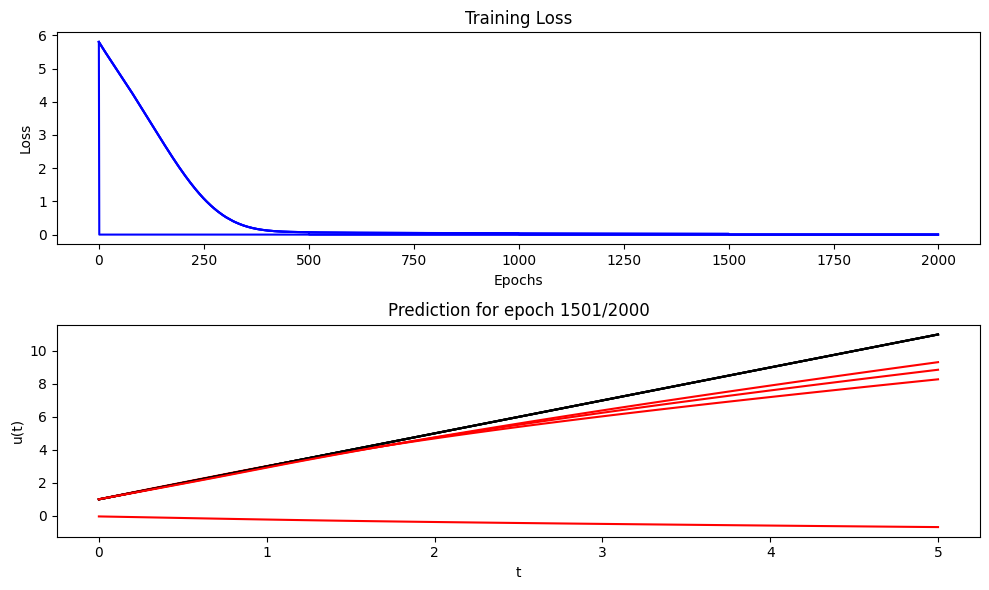

<Figure size 640x480 with 0 Axes>

In [20]:
pinn = Net(input_dim=1, output_dim=1, hidden_dim=32, n_layers=2)

optimizer = optim.Adam(pinn.parameters(), lr=0.0001, weight_decay=1e-4)

Lam = 1 #lambda

### training loop
epochs = 2000

# Prepare the plot
fig, ax = plt.subplots(figsize=(10, 6), nrows=2)
losses = np.zeros(epochs)
epochs_x = np.arange(epochs)

pinn.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    u_pred = pinn(t_train)

    ### ODE loss
    # First derivative of u_pred w.r.t t_train
    u_pred_diff = torch.autograd.grad(u_pred, t_train, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]

    # Second derivative of u_pred w.r.t t_train
    u_pred_diff_diff = torch.autograd.grad(u_pred_diff, t_train, grad_outputs=torch.ones_like(u_pred_diff), create_graph=True)[0]
    
    loss_ODE = torch.mean((u_pred_diff_diff - u_diff_diff(t_train))**2)
        
    ### boundary conditions loss
    loss_bc1 = torch.mean((pinn(t_0) - u_0())**2)

    bc2_diff = torch.autograd.grad(pinn(t_1), t_1, create_graph=True)[0]
    loss_bc2 = torch.mean((bc2_diff - u_diff_1())**2)

    # combined loss
    loss = loss_ODE + Lam*(loss_bc1 + loss_bc2)

    loss.backward()                 # Backward pass: Compute gradient of the loss with respect to model parameters
    optimizer.step()                # Update weights

    losses[epoch] = loss.item()
    
    if epoch % 500 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

        # Plotting the loss
        ax[0].plot(epochs_x, losses, 'b')
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Loss')
        ax[0].set_title('Training Loss')
        # ax.set_xlim(left=max(0, epoch-500), right=epoch+100)  # Adjust the window of displayed data

        # Plotting the function
        ax[1].plot(t_train.detach().numpy(), u_exact.detach().numpy(), 'k', label='Exact')
        ax[1].plot(t_train.detach().numpy(), u_pred.detach().numpy(), 'r', label='Prediction')
        ax[1].set_xlabel('t')
        ax[1].set_ylabel('u(t)')
        ax[1].set_title(f'Prediction for epoch {epoch+1}/{epochs}')
        plt.tight_layout()

        display.clear_output(wait=True)
        display.display(fig)
        
        # Pause a bit so that the plot updates
        plt.pause(0.1)

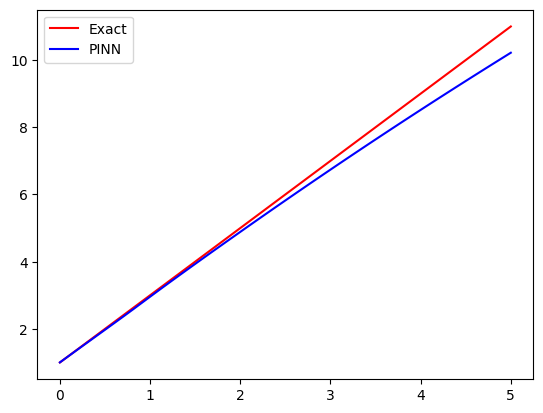

In [17]:
plt.plot(t_train.detach().numpy(), u_exact.detach().numpy(), 'r', label='Exact')
plt.plot(t_train.detach().numpy(), pinn(t_train).detach().numpy(), 'b', label='PINN')
plt.legend()